# The role of drag on the global circulation an Aquaplanet
## Introduction
Until today it remains largely unknown what the role of drag (the extraction of momentum at the surface due to friction) is in the global circulation.

In this BSc-thesis project, you work with output of the ICON climate model, the new climate model of the Max Planck Institute for Meteorology (http://www.mpimet.mpg.de/en/science/models/icon/). The model has been run as an Aquaplanet in a setting with a diurnal cycle, but no seasons. The forcings of the model are symmetric over the equator, which means that the intertropical convergence zone (ITCZ) is centered exactly at the equator and the storm tracks on both hemispheres are equally far from the equator.

## Opening data with the help of Python
In order to be able to do our work with Python, it is necessary to load a number of packages. Their purpose has been addded as comments in the code.

In [1]:
from ipywidgets import interact # Package ipywidgets contains the features of the interactive notebooks.
import numpy as np   # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc # NetCDF has become the standard format for data storage in meteorology and climate sciences.
import matplotlib.pyplot as pl # Matplotlib is a scientific plotting package.
# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nc_wind = nc.Dataset("u_p_3d.nc", "r") # The dataset is loaded in read-only mode.

In [7]:
lat  = nc_wind.variables["lat"] [:]
lon  = nc_wind.variables["lon"] [:]
lev  = nc_wind.variables["lev"] [:]
time = nc_wind.variables["time"][:]

In [4]:
ua = nc_wind.variables["ua"][-4,0,:,:]

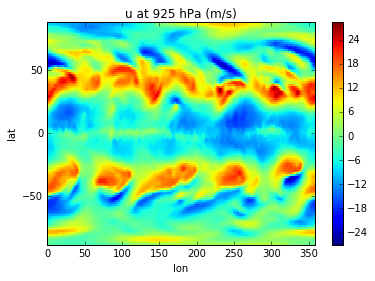

In [5]:
pl.pcolormesh(lon,lat,ua)
pl.colorbar()
pl.xlim(lon.min(), lon.max())
pl.ylim(lat.min(), lat.max())
pl.xlabel("lon")
pl.ylabel("lat")
pl.title("u at 925 hPa (m/s)")

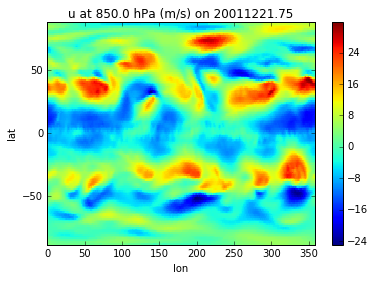

In [15]:
def plot_u_on_p_surface(it=0, ip=0):
    ua = nc_wind.variables["ua"][it,ip,:,:]
    pl.pcolormesh(lon,lat,ua)
    pl.colorbar()
    pl.xlim(lon.min(), lon.max())
    pl.ylim(lat.min(), lat.max())
    pl.xlabel("lon")
    pl.ylabel("lat")
    pl.title("u at {0} hPa (m/s) on {1}".format(lev[ip] / 100., time[it]));
interact(plot_u_on_p_surface, it=(0, time.size), ip=(0,lev.size));